# RNN: Seq2Seq

In [1]:
from datetime import datetime


# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams

rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np 
import normalizers
import optimizer
import custom_plotter

In [3]:
#### Simple RNN architecture class ####
class simple_RNN:
    def __init__(self,layers_dim,**kwargs):
        self.layers_dim = layers_dim
                
        
        # set default values for layer sizes, activation, and scale
        hidden_activation = 'tanh'
        out_activation = 'linear'

        # decide on these parameters via user input
        if 'activation' in kwargs:
            activation = kwargs['activation']
            hidden_activation = activation[0]
            out_activation = activation[1]
        
        # switches
        if hidden_activation == 'linear':
            self.hidden_activation = lambda data: data
        elif hidden_activation == 'tanh':
            self.hidden_activation = lambda data: np.tanh(data)
        elif hidden_activation == 'relu':
            self.hidden_activation = lambda data: np.maximum(0,data)
        elif hidden_activation == 'sinc':
            self.hidden_activation = lambda data: np.sinc(data)
        elif hidden_activation == 'sin':
            self.hidden_activation = lambda data: np.sin(data)
        elif hidden_activation == 'maxout':
            self.hidden_activation = lambda data1,data2: np.maximum(data1,data2)
            
        # switches
        if out_activation == 'linear':
            self.out_activation = lambda data: data
        elif out_activation == 'tanh':
            self.out_activation = lambda data: np.tanh(data)
        elif out_activation == 'relu':
            self.out_activation = lambda data: np.maximum(0,data)
        elif out_activation == 'sinc':
            self.out_activation = lambda data: np.sinc(data)
        elif out_activation == 'sin':
            self.out_activation = lambda data: np.sin(data)
        elif out_activation == 'maxout':
            self.out_activation = lambda data1,data2: np.maximum(data1,data2)
            
    def initializer(self,scale):
        
        layers_dim = self.layers_dim
        W_xh = np.random.randn(layers_dim[1],layers_dim[0]) * scale
        W_hh = np.random.randn(layers_dim[1],layers_dim[1]) * scale
        b_h = np.random.randn(layers_dim[1],1) * scale
        
        W_hidden = [W_xh,W_hh,b_h]
    
        W_hy = np.random.randn(layers_dim[2],layers_dim[1]) * scale
        b_y = np.random.randn(layers_dim[2],1) * scale
    
        W_out = [W_hy,b_y]
        
        W = [W_hidden,W_out]
        return W
        
    def update_equation(self,X_t,H_prev_t,W):
        H_t = self.hidden_activation(np.dot(W[0],X_t) + np.dot(W[1],H_prev_t) + W[2])
        return H_t# H*P
    
    def output_of_hiddenlayer(self,H_t,W):
        Y_t = self.out_activation(np.dot(W[0],H_t) + W[1])
        return Y_t# 1*P
        
    def rnn(self,X_t,H_prev_t,W):
        H_t = self.update_equation(X_t,H_prev_t,W[0])
        Y_predict = self.output_of_hiddenlayer(H_t,W[1])
        
        return Y_predict,H_t

In [4]:
# input_sequence shape should be P*T*N, initial_state shape should be H*1, output_sequence is P*T*M
# This is for one kind of special Seq2Seq architectures 
class RNN:
    def __init__(self,cell,input_sequence,output_sequence,hidden_dim,name,**kwargs):
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence
        
        self.hidden_dim = hidden_dim
        self.P = input_sequence.shape[0]
        self.time_lenth = input_sequence.shape[1]
        self.input_dimension=input_sequence.shape[2]
        self.output_dimension=output_sequence.shape[2]
        
        
        self.scale=0.1
        if 'scale' in kwargs:
            self.scale = scale
    
        if name=='regression': 
            layers_dim = [self.input_dimension,self.hidden_dim,self.output_dimension]
            
        if name=='two_classification':
            layers_dim = [self.input_dimension,self.hidden_dim,1]
            
        if name=='classification':
            if 'num_class' in kwargs:
                self.num_class=num_class
            layers_dim = [self.input_dimension,self.hidden_dim,self.num_class]
        
        #### choice for RNN architecture ####
        if cell=='simple_RNN':
            self.rnn_cell = simple_RNN(layers_dim,**kwargs)
            self.initializer = self.rnn_cell.initializer
        
    def initial_weights(self):
        return self.initializer(self.scale)
             
    def static_rnn(self,W):
        
        initial_state = np.zeros((self.hidden_dim,self.P))
        state = initial_state
        states = [initial_state]
        outputs = []
    
        for t in range(self.time_lenth):
            current_input = self.input_sequence[:,t,:]# P*N
            current_input = current_input.T #N*P
            
            output,state = self.rnn_cell.rnn(current_input,state,W)
            
            outputs.append(output)
            states.append(state)
        
        outputs = np.array(outputs)# T*1*P
        states = np.array(states) # (T+1)*H*P
        
        outputs = outputs.swapaxes(0,2)
        outputs = outputs.swapaxes(1,2)# P*T*1
        states = states[1:]
        states = states.swapaxes(0,2)
        states = states.swapaxes(1,2)# P*T*H
        
        return outputs,states
    
    def model(self,W):
        predict_sequence,states = self.static_rnn(W)
        return predict_sequence
    
    def tuned_model(self,input_X,W):
        initial_state = np.zeros((self.hidden_dim,input_X.shape[0]))
        state = initial_state
        states = [initial_state]
        outputs = []
        
        time_lenth=input_X.shape[1]
        for t in range(time_lenth):
            current_input = input_X[:,t,:]# P*N
            current_input = current_input.T #N*P
            
            output,state = self.rnn_cell.rnn(current_input,state,W)
            
            outputs.append(output)
            states.append(state)
        
        outputs = np.array(outputs)# T*1*P
        states = np.array(states) # (T+1)*H*P
        
        outputs = outputs.swapaxes(0,2)
        outputs = outputs.swapaxes(1,2)# P*T*1
        outputs = self.sigmoid(outputs).astype(int)
        return outputs       
        
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def binary_mse(self,W):
        cost = np.sum((self.sigmoid(self.model(W))-self.output_sequence)**2)
        return cost/float(self.P)
                    
    def cross_entropy(self,W):
        cost= -np.sum(self.output_sequence*np.log(self.sigmoid(self.model(W)))+(1-self.output_sequence)*np.log(1-self.sigmoid(self.model(W))))
        return cost/float(self.P)
                    
    def least_squares(self,W):
        cost = np.sum((self.model(W)-self.output_sequence)**2)
        return cost/float(len(self.output_sequence))
    
    # multiclass softmax
    def multiclass_softmax(self,w):
        # pre-compute predictions on all points
        all_evals = self.model(w).T

        # compute softmax across data points
        a = np.log(np.sum(np.exp(all_evals),axis = 0)) 

        # compute cost in compact form using numpy broadcasting
        b = all_evals[self.output_sequence.astype(int).flatten(),np.arange(np.size(self.output_sequence))]
        cost = np.sum(a - b)

        # return average
        return cost/float(np.size(self.output_sequence))

    # multiclass misclassification cost function - aka the fusion rule
    def multiclass_counting_cost(self,w):                
        # pre-compute predictions on all points
        all_evals = self.model(w).T

        # compute predictions of each input point
        y_predict = (np.argmax(all_evals,axis = 0))[np.newaxis,:]

        # compare predicted label to actual label
        count = np.sum(np.abs(np.sign(self.output_sequence - y_predict)))

        # return number of misclassifications
        return count

# Ex: Binary Addtion Problem

In [5]:
# Create dataset
nb_train = 2000  # Number of training samples
# Addition of 2 n-bit numbers can result in a n+1 bit number
sequence_len = 7  # Length of the binary sequence

def create_dataset(nb_samples, sequence_len):
    """Create a dataset for binary addition and return as input, targets."""
    max_int = 2**(sequence_len-1) # Maximum integer that can be added
    format_str = '{:0' + str(sequence_len) + 'b}' # Transform integer in binary format
    nb_inputs = 2  # Add 2 binary numbers
    nb_outputs = 1  # Result is 1 binary number
    X = np.zeros((nb_samples, sequence_len, nb_inputs))  # Input samples
    T = np.zeros((nb_samples, sequence_len, nb_outputs))  # Target samples
    # Fill up the input and target matrix
    for i in range(nb_samples):
        # Generate random numbers to add
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)
        # Fill current input and target row.
        # Note that binary numbers are added from right to left, but our RNN reads 
        #  from left to right, so reverse the sequence.
        X[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1)]))
        X[i,:,1] = list(reversed([int(b) for b in format_str.format(nb2)]))
        T[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1+nb2)]))
    return X, T

# Create training samples
X_train, Y_train = create_dataset(nb_train, sequence_len)
print('X_train shape: {0}'.format(X_train.shape))
print('Y_train shape: {0}'.format(Y_train.shape))

X_train shape: (2000, 7, 2)
Y_train shape: (2000, 7, 1)


## Set up seq2seq simple RNN

In [6]:
binary_addition = RNN(cell='simple_RNN',input_sequence=X_train,output_sequence=Y_train,hidden_dim=3,name='two_classification')
w_init = binary_addition.initial_weights()

## Training: Using the binary_mse(sigmoid+least square) as the cost function.

In [7]:
startTime= datetime.now()

g = binary_addition.binary_mse
w = w_init
alpha_choice = 10**(-1)
max_its = 2000
version = 'normalized'
weight_history =  optimizer.gradient_descent(g,w,alpha_choice,max_its,version,verbose = True)

timeElapsed=datetime.now()-startTime 

print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

started iteration 0 of 2000
started iteration 5 of 2000
started iteration 10 of 2000
started iteration 15 of 2000
started iteration 20 of 2000
started iteration 25 of 2000
started iteration 30 of 2000
started iteration 35 of 2000
started iteration 40 of 2000
started iteration 45 of 2000
started iteration 50 of 2000
started iteration 55 of 2000
started iteration 60 of 2000
started iteration 65 of 2000
started iteration 70 of 2000
started iteration 75 of 2000
started iteration 80 of 2000
started iteration 85 of 2000
started iteration 90 of 2000
started iteration 95 of 2000
started iteration 100 of 2000
started iteration 105 of 2000
started iteration 110 of 2000
started iteration 115 of 2000
started iteration 120 of 2000
started iteration 125 of 2000
started iteration 130 of 2000
started iteration 135 of 2000
started iteration 140 of 2000
started iteration 145 of 2000
started iteration 150 of 2000
started iteration 155 of 2000
started iteration 160 of 2000
started iteration 165 of 2000
st

started iteration 1365 of 2000
started iteration 1370 of 2000
started iteration 1375 of 2000
started iteration 1380 of 2000
started iteration 1385 of 2000
started iteration 1390 of 2000
started iteration 1395 of 2000
started iteration 1400 of 2000
started iteration 1405 of 2000
started iteration 1410 of 2000
started iteration 1415 of 2000
started iteration 1420 of 2000
started iteration 1425 of 2000
started iteration 1430 of 2000
started iteration 1435 of 2000
started iteration 1440 of 2000
started iteration 1445 of 2000
started iteration 1450 of 2000
started iteration 1455 of 2000
started iteration 1460 of 2000
started iteration 1465 of 2000
started iteration 1470 of 2000
started iteration 1475 of 2000
started iteration 1480 of 2000
started iteration 1485 of 2000
started iteration 1490 of 2000
started iteration 1495 of 2000
started iteration 1500 of 2000
started iteration 1505 of 2000
started iteration 1510 of 2000
started iteration 1515 of 2000
started iteration 1520 of 2000
started 

In [8]:
cost_history=[g(w) for w in weight_history]

<IPython.core.display.Javascript object>


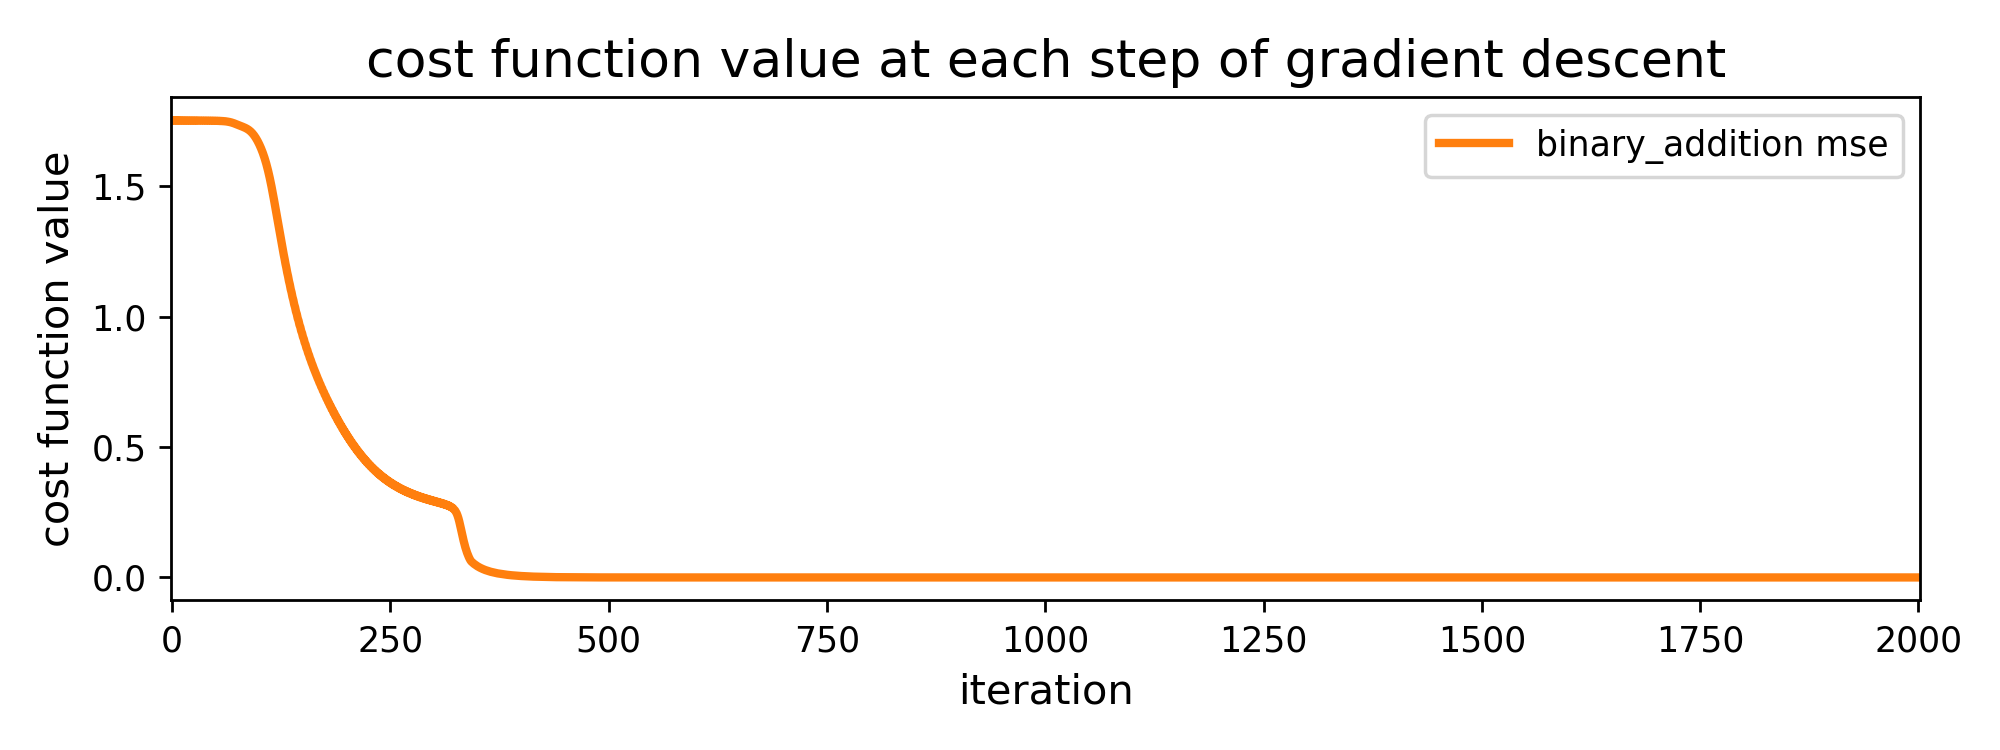

In [9]:
plotter_demo = custom_plotter.Visualizer()

# plot cost function history
start = 0   # at which iteration to begin plotting the cost function history
cost_histories = [[],cost_history]

labels = ['','binary_addition mse']
plotter_demo.compare_regression_histories(cost_histories,start = start,labels = labels)

In [14]:
print(cost_history[-1])

1.1512438835569142e-32


# Testing/Prediction: training on 7bits, but we can implement on any bits test, here we use 15bits as test

In [10]:
# Create Testing dataset
nb_test = 2  # Number of Testing samples
sequence_len =15
# Create Testing samples
X_Test, Y_Test = create_dataset(nb_test, sequence_len)
print('X_Test shape: {0}'.format(X_Test.shape))

X_Test shape: (2, 15, 2)


In [11]:
best_weights=weight_history[-1]

In [12]:
Y_predict=binary_addition.tuned_model(X_Test,best_weights)

## Compare the truth label with predict label

In [13]:
print(X_Test[0])
print(Y_predict[0])
print('----------------------------')
print(X_Test[1])
print(Y_predict[1])

[[1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]]
[[0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]
----------------------------
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]]
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]]
